# $i$-RevNet and $i$-ResNet: Minor modifications to get an invertible neural network!

Our objective will be to design some neural networks that will be invertible.

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

We first consider the model architecture given by: (it's a VGG-like model)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv2 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv3 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv4 = nn.Conv2d(16, 16, 7,padding=3)
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return x

The routines to load the data from the dataset are given by:

In [ ]:
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Subset

reshape = transforms.Lambda(lambda x:x.view(16,7,7))

dataset=torchvision.datasets.MNIST('./', download=True, transform=transforms.Compose([transforms.ToTensor(),reshape]), train=True)
train_indices = torch.arange(0,500)#torch.randperm(len(dataset))[:500]
train_dataset = Subset(dataset, train_indices)

dataset=torchvision.datasets.MNIST('./', download=True, transform=transforms.Compose([transforms.ToTensor(),reshape]), train=False)
test_indices = torch.arange(0,10000)#torch.randperm(len(dataset))[:1000]
test_dataset = Subset(dataset, test_indices)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



and the dataloader, which is actually used to depile the data is given by:

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                          shuffle=False, num_workers=0)

1. Try to visualize some data that we will use along this lab session.

In [ ]:
print(len(trainloader))
print(len(testloader))

8
625


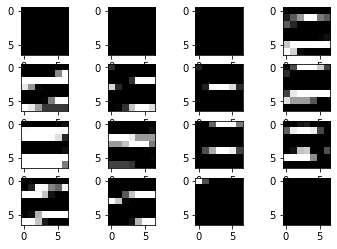

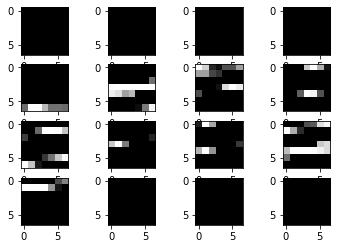

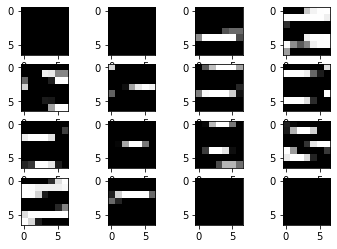

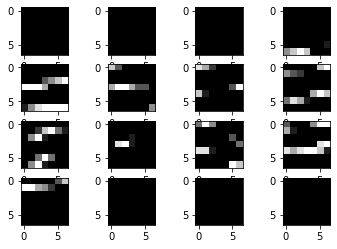

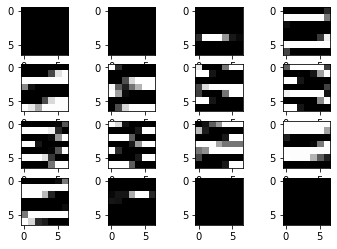

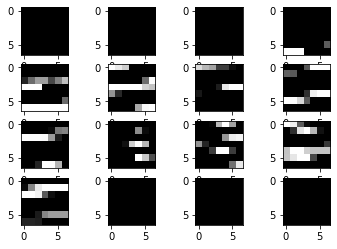

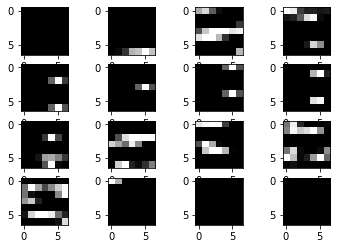

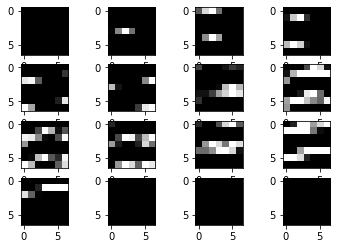

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Vizualisation data
for data, lbl in trainloader:
  fig, axes = plt.subplots(4, 4)
  for i, ax in enumerate(axes.flat):
    ax.imshow(data[0][i], cmap='gray')
  plt.show()



2. Write a train function and a test function on this dataset. Train the neural network, and plot the training loss. __Hint:__ Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html .

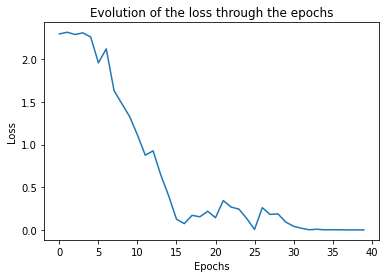

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 82 %


In [ ]:
import numpy as np
def train(net, n_epoch=40, learning_rate=0.05):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    global_loss = []

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        #running_loss = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # running_loss += loss.item()
            # if i % 8 == 0: 
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.3f}')
            #     running_loss = 0.0
        global_loss.append(loss.item())
            
            # FILL IN HERE
    plt.plot(np.arange(n_epoch), global_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution of the loss through the epochs')
    plt.show()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 500 train images: %d %%' % (
        100 * correct / total))
    
    return net

def test(net):
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 500 test images: %d %%' % (
            100 * correct / total))
        
net = Net()
net = train(net)
test(net)

# $i$-RevNets: NNs invertible by constructions
3. For a layer $j$, assume the features at layer write $X_j=[x_j,\tilde x_j]$ where $\text{dim}(x_j)=n_j$ and $\text{dim}(\tilde x_j)=m_j$ , let $F_j:\mathbb{R}^{n_j}\rightarrow \mathbb{R}^{m_{j+1}}$. Propose an invertible $\Phi_F$ architecture using only $F=(F_1,...F_J)$ and additions. We write $\mathcal{F}_J=\cup_{F} \{\Phi_{F}\}$ the set of such neural networks of depth $J$ for any width $m_j,n_j$.

To construct an invertible neural network using only $F=(F_1,...F_J)$ and additions, we can use the following architecture:

1. Split the input features $X_0$ into two parts: $x_0$ and $\tilde x_0$.
2. For $j \in \lbrack1,...,J\rbrack$:
- Forward:
 - $ \tilde x_{j} = F_j(\tilde x_{j-1}) + x_j$.
- Inverse:
 - $x_{j} = \tilde x_{j-1} - F_j(x_{j-1})$.

The set of neural networks that can be constructed using this architecture is denoted by $\mathcal{F}_J$.

4. Write $\mathcal{F}=\cup_J \mathcal{F}_J$. Give a necessary and suffisant condition for $\mathcal{F}$ to be a group.

To determine whether $\mathcal{F}$ is a group, we need to verify that it satisfies the three following axioms:

- Identity: 
The identity neural network is the $i$-RevNet architecture with only identity mappings at each layer.

- Associativity: 
The composition of neural networks in $\mathcal{F}$ is also an $i$-RevNet architecture, and it is independent of the order of composition.

- Invertibility: 
Let $f^{-1}$ be the inverse of a neural network $f\in\mathcal{F}$. $f^{-1}$ is an $i$-RevNet architecture. Thus, the inverse is in $\mathcal{F}$.

We can conclude that $\mathcal{F}$ is a group if and only if each neural network in $\mathcal{F}$ has an inverse neural network in $\mathcal{F}$ denoted $f^{-1}$, ie $\mathcal{F}$ must be invertible.

5. Write a function that splits a tensor of size $(batch, chan, N, N)$ into two tensors of size $(batch, chan//2, N, N)$

In [ ]:
class SplitAlongChannels(nn.Module):
    def __init__(self):
        super(SplitAlongChannels, self).__init__()
        pass
    def forward(self, x):
        batch, c, w, h = x.size()
        return (x[:, :c//2, :, :], x[:, c//2:, :, :])


6. Write the corresponding invertible operation.

In [ ]:
class InvertibleLayer(nn.Module):
    def __init__(self, kernel_size=7):
        super(InvertibleLayer, self).__init__()
        self.conv = nn.Conv2d(8, 8, kernel_size , padding=kernel_size//2)

    def forward(self, x_in):
        x1, x2 = x_in[0], x_in[1] 
        out = self.conv(x2) + x1
        return (x2, out)
        
    def inverse(self, x_in):
        x2, y1 = x_in[0], x_in[1]
        x1 = y1 - self.conv(x2)
        return (x1, x2)

7. Write a class i-RevNet that consists in 4 layers, which is analog to *Net*.

In [ ]:
class iRevNet(nn.Module):
    def __init__(self):
        super(iRevNet, self).__init__()
        self.split = SplitAlongChannels()
        self.conv1 = InvertibleLayer()
        self.conv2 = InvertibleLayer()
        self.conv3 = InvertibleLayer()
        self.conv4 = InvertibleLayer()
        self.fc = nn.Linear(28*28, 10)
        self.bn1 = nn.BatchNorm2d(16, momentum=0.9)
        
    def forward(self, x_in, classif=True):
        x = self.split.forward(x_in)
        x = self.conv1.forward(x)
        x = self.conv2.forward(x)
        x = self.conv3.forward(x)
        x = self.conv4.forward(x)
        x_bij = torch.cat((x[0], x[1]), 1)
        if classif:
          x = F.relu(self.bn1(x_bij))
          x = F.avg_pool2d(x, 1)
          x = x.view(-1, 28*28)
          x = self.fc(x)
        return x
    
    def inverse(self, x_in):
        #x = self.split.inverse(x_in)
        x = self.conv4.inverse(x_in)
        x = self.conv3.inverse(x)
        x = self.conv2.inverse(x)
        x = self.conv1.inverse(x)
        out = torch.cat((x[0], x[1]), 1)
        return out

8. Implement and run such architecture using the questions above. Compare the accuracies.

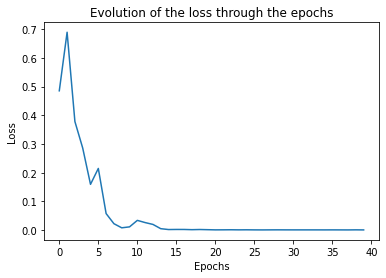

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 84 %


In [ ]:
net = iRevNet()
net = train(net)
test(net)

9. Validate on an example that your model is exactly invertible.

In [ ]:
x = torch.randn(1,16,7,7)
print('Input size before processing it in the network : {}'.format(x.size()))
# Pass forward without classification
net = iRevNet()
out = net(x, classif=False)

# Inverse the output to get the original input
x_inv = net.inverse(out)
print('Sum of distances between out and input : ', (x_inv[0]-x[0]).sum(), ' which is almost 0 due to informatic approximation')
print('Input size after processing it "backward" in the network : {}'.format(x_inv.size()))

Input size before processing it in the network : torch.Size([1, 16, 7, 7])
Sum of distances between out and input :  tensor(-1.0929e-06, grad_fn=<SumBackward0>)  which is almost 0 due to informatic approximation
Input size after processing it "backward" in the network : torch.Size([1, 16, 7, 7])


On retrouve exactement notre x initial après avoir inversé notre output, comme attendu notre modèle est exactement inversible.

This type of model is directly linked to: https://openreview.net/pdf?id=HJsjkMb0Z.

# $i$-ResNets: a simple modification to get an invertible resnet

We know consider the following class model, to which we refer as ResNet (see https://arxiv.org/abs/1512.03385):

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv2 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv3 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv4 = nn.Conv2d(16, 16, 7,padding=3)
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x - F.relu(self.conv1(x))
        x = x - F.relu(self.conv2(x))
        x = x - F.relu(self.conv3(x))
        x = x - F.relu(self.conv4(x))
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return x

Note that those models have some identity loop, to which we refer as skip-connections, that were introduced in https://arxiv.org/abs/1512.03385.

10. Train the corresponding model.

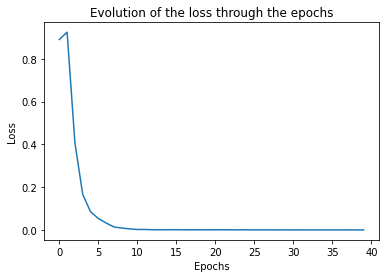

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 85 %


In [ ]:
net=ResNet()
net = train(net)
test(net)

11. Let's consider the layer of a Neural Net given by $x_{j+1}=x_j - F_j x_j$. Propose a condition on $F=(F_1,...,F_J)$ for $\Phi x$ to be invertible. Propose a simple iterative way to compute the inverse. How many iterations are needed to obtain a precision $\epsilon$?

Consider the layer of a neural network given by $x_{j+1} = x_j - F_j x_j$, where $x_j\in\mathbb{R}^{n_j}$ and $F_j\in\mathbb{R}^{n_j\times n_j}$ for $j=1,\ldots,J$. 

- To ensure that $\Phi x$ is invertible, we need to ensure that the Jacobian matrix $J(x)$ of the function $\Phi x = x_J - \sum_{j=1}^J F_j(x_j)$ has a non-null determinant.

$det(J(x)) = \prod_{j=1}^J det(I-F_j)$

Thus, for $\Phi x$ to be invertible, we need $\det(I - F_j) \neq 0$ for all $j=1,\ldots,J$.

- To compute the inverse of $\Phi x$, we use an iterative procedure:

 - Set $y_J = x_J$
 - For $j=J-1,\ldots,1$: Compute $x_j = x_{j+1} + F_j(x_j)$
 - $\Phi^{-1} x = x_1$

- The number of iterations needed to obtain a precision $ɛ$ will depend on the values of $F_j$ and of the input $x$.


 

12. Let be $N$ an integer,  $x\in \ell^2([0,N-1])$. Compute the norm of $W:y\rightarrow x\circledast  y$. Deduce a simple renormalization procedure to constraint $\Vert DF_j\Vert\leq\rho$ for some $0<\rho<1$.

The norm of $W$ can be computed as follows:
\begin{align*}
\|W\|^2 &= \max_{\|y\|=1} \|Wy\| \\
&= \max_{\|y\|=1} \sqrt{\langle Wy,Wy \rangle} \\
&= \max_{\|y\|=1} \sqrt{\langle U \Sigma V^T y,U \Sigma V^T y \rangle} \\
&= \max_{\|y\|=1} \sqrt{\langle y,V \Sigma^2 V^T y \rangle} \\
&= \max_{\|y\|=1} \sqrt{\langle V^T y, \Sigma^2 V^T y \rangle},
\end{align*}
Let $z = V^Ty$, thus $\|z\|=1$.

Then,
\begin{align*}
\|W\|^2 &= \max_{\|z\|=1} \sqrt{\langle z, \Sigma^2 z \rangle}
\end{align*}

And, $\sqrt{\langle z, \Sigma^2 z \rangle} = \sum_{i=0}^{N-1} \sigma_i^2 z_i^2$, with $\sum_{i=0}^{N-1} z_i^2=1$.

Thus,
$\sqrt{\langle z, \Sigma^2 z \rangle} \le \sigma_{N}^2 \sum_{i=0}^{N-1} z_i^2 = \sigma_{N}^2$

So, $\|W\|_2 = |\sigma_{N}| = \sigma_{N}$

We can then deduce a simple renormalization procedure to constraint $|DF_j|\leq \rho$ for $0 < \rho < 1$, we can simply renormalize by setting $\frac{\rho}{\|W\|_2}$. 



13. Implement this layer and incorporate the normaliztion in the train function. You might want to look at the help of nn.Conv2D to access the weight of the conv. __Hint__: modify a parameter using .data to avoid breaking the tree of computation of pytorch.

In [ ]:
class InvertibleResidual(nn.Module):
    
    def __init__(self, kernel_size=7):
        super(InvertibleResidual, self).__init__()
        self.conv = nn.Conv2d(16, 16, kernel_size,padding=kernel_size//2)
        
    def forward(self, x):
        return x - F.relu(self.conv(x))
    
    def normalize(self, rho=0.9):
        #weight = self.conv.weight
        #sigma = torch.linalg.norm(weight)
        #norm = torch.max(torch.ones(1), sigma / rho)
        #weight = weight / (norm + 1e-5)  
        #return weight
        return rho * self.conv.weight.data/(torch.norm(self.conv.weight.data)+1e-5)

    
    def inverse(self, y):
        return y + F.relu(self.conv(y))

In [ ]:
def train_norm(net, n_epoch=40, learning_rate=0.05):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    global_loss = []

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        #running_loss = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()
            net = net.normalize()
            out = net.forward(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # running_loss += loss.item()
            # if i % 8 == 0: 
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 16:.3f}')
            #     running_loss = 0.0
        global_loss.append(loss.item())
            
    plt.plot(np.arange(n_epoch), global_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution of the loss through the epochs')
    plt.show()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 500 train images: %d %%' % (
        100 * correct / total))
    
    return net

def test(net):
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 500 test images: %d %%' % (
            100 * correct / total))
    
    return net

14. Write a class i-ResNet, and train it.

In [ ]:
class iResNet(nn.Module):
    def __init__(self):
        super(iResNet, self).__init__()
        self.conv1 = InvertibleResidual()
        self.conv2 = InvertibleResidual()
        self.conv3 = InvertibleResidual()
        self.conv4 = InvertibleResidual()
        self.fc = nn.Linear(28*28, 10)
    
    def normalize(self, rho=0.9):
        self.conv1.weight = self.conv1.normalize()
        self.conv2.weight = self.conv2.normalize()
        self.conv3.weight = self.conv3.normalize()
        self.conv4.weight = self.conv4.normalize()
        return self

    def forward(self, x_in, classif=True):
        x = self.conv1.forward(x_in)
        x = self.conv2.forward(x)
        x = self.conv3.forward(x)
        x = self.conv4.forward(x)
        if classif:
          x = x.view(-1, 28*28)
          x = self.fc(x)
        return x

    
    def inverse(self, x_in):
        x = self.conv4.inverse(x_in)
        x = self.conv3.inverse(x)
        x = self.conv2.inverse(x)
        x = self.conv1.inverse(x)
        return x


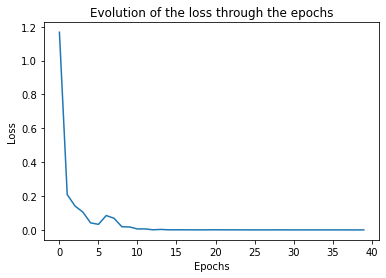

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 86 %


iResNet(
  (conv1): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv2): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv3): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv4): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
net = iResNet()
net = train_norm(net)
test(net)

15. Verify the invertibility of the final model.

In [ ]:
x = torch.randn(1,16,7,7)
print('Input size before processing it in the network : {}'.format(x.size()))
# Pass forward without classification
net = iResNet().normalize()
out = net(x, classif=False)

# Inverse the output to get the original input
x_inv = net.inverse(out)
print('Sum of distances between out and input : ', (x_inv[0]-x[0]).sum(), ' which is way higher than the exact inversibility of iRevNet but it still is great')
print('Input size after processing it "backward" in the network : {}'.format(x_inv.size()))

Input size before processing it in the network : torch.Size([1, 16, 7, 7])
Sum of distances between out and input :  tensor(31.1229, grad_fn=<SumBackward0>)  which is way higher than the exact inversibility of iRevNet but it still is great
Input size after processing it "backward" in the network : torch.Size([1, 16, 7, 7])


This type of model is quite discussed in https://arxiv.org/pdf/1811.00995.pdf.

16. For some invertible neural networks $\Phi$ and two images $x_0,x_1$, visualize for $0<t<1$ $x_t=\Phi^{-1}((1-t)\Phi x_0+t\Phi x_1$. What do you think?

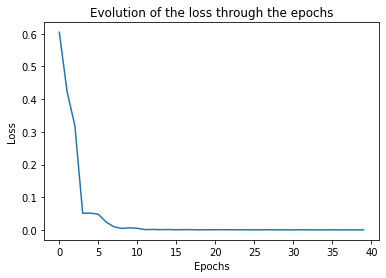

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 84 %


iRevNet(
  (split): SplitAlongChannels()
  (conv1): InvertibleLayer(
    (conv): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv2): InvertibleLayer(
    (conv): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv3): InvertibleLayer(
    (conv): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv4): InvertibleLayer(
    (conv): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
)

In [ ]:
net = iRevNet()
net = train(net)
test(net)

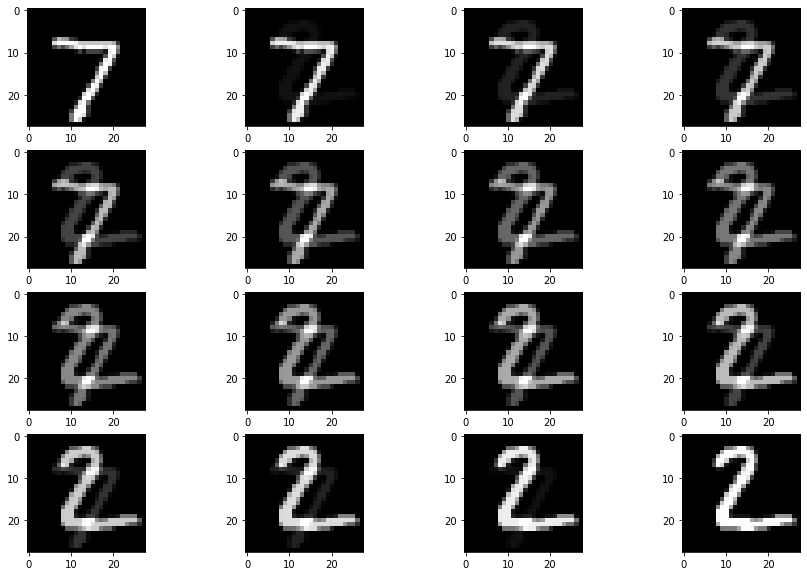

In [ ]:
# First test with iRevNet
import matplotlib.pyplot as plt
import numpy as np

im1 = test_dataset[0][0].unsqueeze(0)
im2 = test_dataset[1][0].unsqueeze(0)

fig, axes = plt.subplots(4, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
  t = i/15
  im_t = net.inverse([(1-t)*net(im1, classif=False)[i]+t*net(im2, classif=False)[i] for i in range(2)])
  ax.imshow(im_t.detach().numpy()[0].reshape(1, 28, 28)[0], cmap='gray')
plt.show()


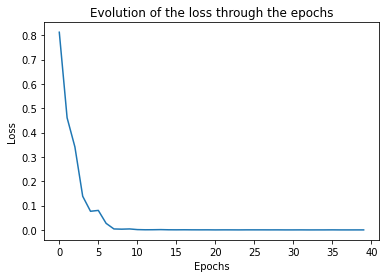

Accuracy of the network on the 500 train images: 100 %
Accuracy of the network on the 500 test images: 86 %


iResNet(
  (conv1): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv2): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv3): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (conv4): InvertibleResidual(
    (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
net = iResNet().normalize()
net = train_norm(net)
test(net)

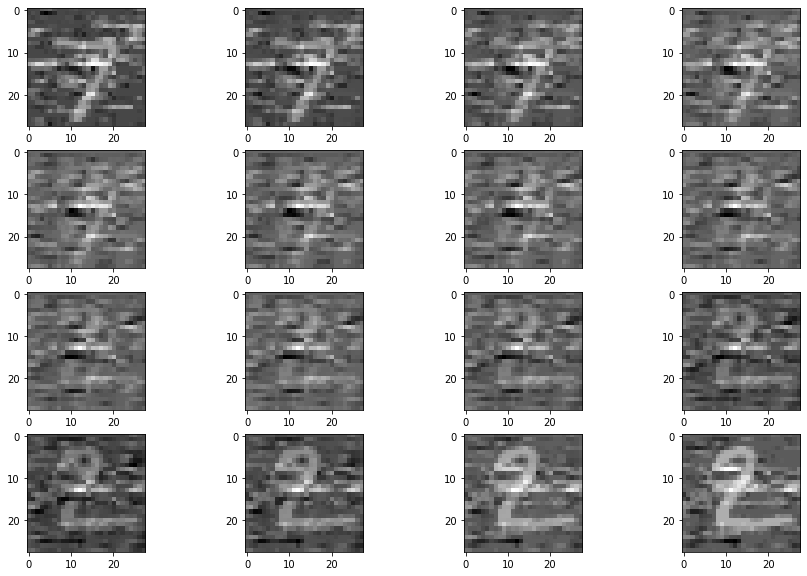

In [ ]:
# Second test with iResNet

import matplotlib.pyplot as plt
import numpy as np

im1 = test_dataset[0][0].unsqueeze(0)
im2 = test_dataset[1][0].unsqueeze(0)

fig, axes = plt.subplots(4, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
  t = i/15
  im_t = net.inverse((1-t)*net(im1, classif=False)+t*net(im2, classif=False))
  ax.imshow(im_t.detach().numpy()[0].reshape(28, 28), cmap='gray')
plt.show()

# We can observe that the diffences between the exact inversibility of the irevnet and the noisy inversibility of iresnet

We can observe that the diffences between the exact inversibility of the i-Revnet and the noisy inversibility of i-Resnet.

17. Explain the major differences between the two approaches, the pros and the cons.

- **Architecture:** 

i-Revnet uses reversible blocks, that are exactly invertible. It consists on building a cascade of homeomorphic layers, which preserves the mutual information between input and hidden representation and shows that the loss of information can only occur at the final layer. i-RevNets retain all information about the input signal in any of their intermediate representations up until the last layer.

Whereas i-Resnet is uses skip connections, thus this architecture is more flexible. i- ResNets can be constructed by simply changing the normalization scheme of standard ResNets. This approach allows unconstrained architectures for each residual block, while only requiring a Lipschitz constant smaller than one for each block.


i-Resnet has a free-form, which is not the case of i-Revnet.

- **Invertibility:** 

i-Revnet are exactly invertible. i-Resnet are approximately invertible, as we can see in the question 16. 

Weight Normalization makes the linear layers injective by dividing the weights of each filter by their norm. This division allows each filter to be projected onto a unit sphere centred at the origin of the weight space.

This method ensures that the norm of the inputs is preserved after multiplication with the normalised weights. This means that each input has a unique output, which is an essential property for the layer to be injective.

To be more precise, let $x \in \mathbb{R}^n$ be an input vector and $W \in \mathbb{R}^{m \times n}$ the matrix of non-normalized weights of a linear layer. The output $y \in \mathbb{R}^m$ of this layer is calculated by the matrix multiplication $y = Wx$. With the normalization, as we have seen before,
$y = \frac{\rho W}{\sqrt{(W^TW)}}x = \frac{\rho W}{\sigma_{max}}x$ if $\frac{\rho}{\sigma_{max}} < 1$

As the matrix $W^\top W$ is symmetric positive definite, it is diagonalizable and its eigenvalues are positive. Therefore, $\sqrt{(W^\top W) }$ is a positive quantity, which guarantees that the normalised output is well defined and unique for each input.


The normalization that can make iResNet invertible affect the network pretty badly. Indeed, the calculation of the inverse of the normalized weight matrix are pretty expensive in terms of computation time and memory and it may also introduce numerical and stability problems.

- **Normalization:** 

i-Revnet do not use normalization because it has to be exactly invertible. Whereas i-Resnet use normalization, it can thus reduce overfitting. This weight normalization can affect the performances of the network because this technique can change the curvature of the error surface, which can make optimization more difficult. Indeed, the gradients of the error with respect to the parameters are modified by the normalisation, which can make the gradients les regular and stable during optimisation. This normalization can also introduce biases by affecting the distribution of activations of the previous layer, which can limit the ability of the network to learn accurate representations which is a con for the iResNet.


- **Exact Likelihood:**

i-Revnet computes exact likelihood, while i-Resnet computes non-exact likelihood.
i-ResNet can be trained as maximum likelihood generative model on unlabeled data. To compute likelihood, we introduce a tractable approximation to the Jacobian determinant of a residual block.
